# Energy Usage

## Motivation
I've recently had two Nest thermostats installed in my house and would like to know if it reduces my energy usage over the winter. I've taken my gas readings from the past year and want to get an idea of what my usage looks like now and what it might look like. In the future when I input more recent date I should be able to identify any changes. Nest was installed on 21/11/19

In [ ]:
import pandas as pd

Let's start by reading in a CSV of current readings and seeing what information we can glean.

In [26]:
dtypes = {'Date':'str', 'Gas Usage (Units)':'int64'}
gas_df = pd.read_csv('data/Energy Usage - Gas.csv', dtype = dtypes, parse_dates=['Date'], dayfirst=True)

In [27]:
gas_df.set_index('Date', inplace=True)

In [28]:
gas_df

,Gas Usage (Units)
Date,
2018-10-22,2404
2018-11-04,2427
2018-12-21,2524
2019-01-25,2602
2019-03-01,2675
2019-04-24,2764
2019-07-17,2804
2019-08-03,2812
2019-08-25,2822


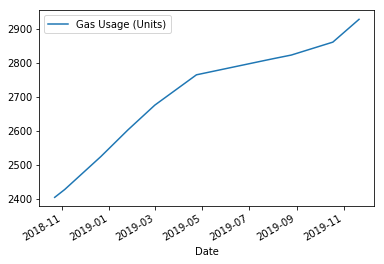

In [29]:
gas_df.plot()

A quick glance at the data shows that the readings aren't evenly spaced. Some months are missing and some have two readings. It will probably help to interpolate the data to smooth this out. Similarly the graph doesn't tell us much as it is continually increasing. A usage per month would be more useful.

In [32]:
gas_df_reindexed = gas_df.reindex(pd.date_range(start=gas_df.index.min(),
                                                  end=gas_df.index.max(),
                                                  freq='1D')) 

In [33]:
gas_df_reindexed.head()

,Gas Usage (Units)
2018-10-22,2404.0
2018-10-23,NaN
2018-10-24,NaN
2018-10-25,NaN
2018-10-26,NaN


In [35]:
gas_df_reindexed.interpolate(method='linear', inplace=True)

In [36]:
gas_df_reindexed.head()

,Gas Usage (Units)
2018-10-22,2404.000000
2018-10-23,2405.769231
2018-10-24,2407.538462
2018-10-25,2409.307692
2018-10-26,2411.076923


In [50]:
# Get the value at the last day of every month
gas_df_reindexed = gas_df_reindexed.groupby(pd.Grouper(freq='M')).nth(0)

In [51]:
gas_df_reindexed

,Gas Usage (Units)
2018-10-31,2404.000000
2018-11-30,2421.692308
2018-12-31,2482.723404
2019-01-31,2548.514286
2019-02-28,2616.600000
2019-03-31,2675.000000
2019-04-30,2726.092593
2019-05-31,2767.333333
2019-06-30,2782.095238
2019-07-31,2796.380952


In [53]:
gas_df_reindexed['Monthly Usage'] = gas_df_reindexed.diff()['Gas Usage (Units)']

In [55]:
gas_df_reindexed

,Gas Usage (Units),Monthly Usage
2018-10-31,2404.000000,NaN
2018-11-30,2421.692308,17.692308
2018-12-31,2482.723404,61.031097
2019-01-31,2548.514286,65.790881
2019-02-28,2616.600000,68.085714
2019-03-31,2675.000000,58.400000
2019-04-30,2726.092593,51.092593
2019-05-31,2767.333333,41.240741
2019-06-30,2782.095238,14.761905
2019-07-31,2796.380952,14.285714


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

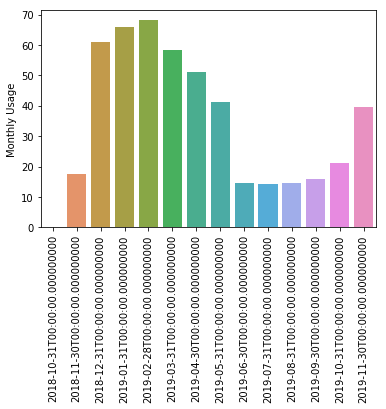

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=gas_df_reindexed, x=gas_df_reindexed.index, y=gas_df_reindexed['Monthly Usage'])
plt.xticks(rotation=90)